In [14]:
import os
os.chdir("../src/")
import numpy as np
import scipy.spatial as spatial
import torch
import torchvision
import matplotlib.pyplot as plt
from captum.attr import visualization as viz

from models.resnet import ResNet18 as ResNet18_ReLu
from models.resnet_softplus_10 import ResNet18
from sparse_expl_attacks import image_datasets_dir, models_weights_dir, output_dir
from sparse_expl_attacks.sparse_attack import SparseAttack
from sparse_expl_attacks.utils import DifferentiableNormalize, get_expl, topk_intersect

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Attack params
num_iter = 100
lr = 0.1
expl_method = "saliency"
topk = 20
max_num_features = 20
gamma = 1e1

In [3]:
# Set the device (cpu or gpu).
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
SEED = 72
# Set the seed.
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
# Defining the normalizer for CIFAR-10 images.
data_mean = np.array([0.4914, 0.4822, 0.4465])
data_std = np.array([0.2023, 0.1994, 0.2010])
normalizer = DifferentiableNormalize(mean=data_mean, std=data_std)
# Loading the CIFAR-10 test dataset.
cifar_test = torchvision.datasets.CIFAR10(
    root=os.path.join(image_datasets_dir, "cifar-10"),
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
)

test_loader = torch.utils.data.DataLoader(cifar_test, batch_size=128, shuffle=True)
BATCH_SIZE = 16
indices = np.random.randint(128, size=BATCH_SIZE)
# Load images.
dataiter = iter(test_loader)
images_batch, labels_batch = next(dataiter)
examples = images_batch[indices].to(device)
labels = labels_batch[indices].to(device)

Files already downloaded and verified


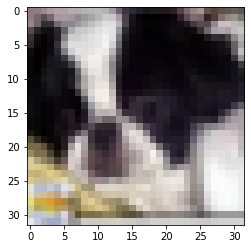

In [5]:
# Show a sample image
# Convert torch tensor to image
img = examples[0:1].permute(0, 2, 3, 1)
img = img.contiguous().squeeze().detach().cpu().numpy()
img = np.clip(img, 0, 1)
plt.imshow(img)

In [6]:
# Softplus model
model = ResNet18()
model.load_state_dict(torch.load(os.path.join(models_weights_dir, "RN18_standard.pth"))["net"])
model = model.eval().to(device)
# ReLu model
model_relu = ResNet18_ReLu()
model_relu.load_state_dict(
    torch.load(os.path.join(models_weights_dir, "RN18_standard.pth"))["net"]
)
model_relu = model_relu.eval().to(device)

In [7]:
# Keep only instances for which the model prediction is correct.
with torch.no_grad():
    preds = model_relu(normalizer.forward(examples)).argmax(dim=1).detach()
    samples_to_pick = preds == labels
    examples = examples[samples_to_pick]
    labels = labels[samples_to_pick]
BATCH_SIZE = examples.size()[0]
print(f"number of samples: {examples.size()[0]}")

number of samples: 15


In [8]:
# Perform the attack.
sparse_attack = SparseAttack(
    model=model,
    model_relu=model_relu,
    expl_method=expl_method,
    num_iter=num_iter,
    lr=lr,
    topk=topk,
    max_num_features=max_num_features,
    gamma=gamma,
    normalizer=normalizer,
)

In [9]:
sparse_attack

In [10]:
x_adv_single_step = sparse_attack.attack(
    attack_type="single_step", x_input=examples, y_input=labels
)

x_adv_pgd0 = sparse_attack.attack(
    attack_type="pgd0", x_input=examples, y_input=labels
)

x_adv_greedy = sparse_attack.attack(
    attack_type="greedy", x_input=examples, y_input=labels
)


In [12]:
# Compute the explanation of a sample image for vizualising the result.
b = 0
org_expl = get_expl(
    model, 
    normalizer.forward(examples[b:b+1]), 
    expl_method, 
    device,
    labels[b:b+1], 
    normalize=False)

adv_expl_single_step = get_expl(
    model, 
    normalizer.forward(x_adv_single_step[b:b+1]), 
    expl_method, 
    device,
    labels[b:b+1], 
    normalize=False)

adv_expl_pgd0 = get_expl(
    model, 
    normalizer.forward(x_adv_pgd0[b:b+1]), 
    expl_method, 
    device,
    labels[b:b+1], 
    normalize=False)

adv_expl_greedy = get_expl(
    model, 
    normalizer.forward(x_adv_greedy[b:b+1]), 
    expl_method, 
    device,
    labels[b:b+1], 
    normalize=False)

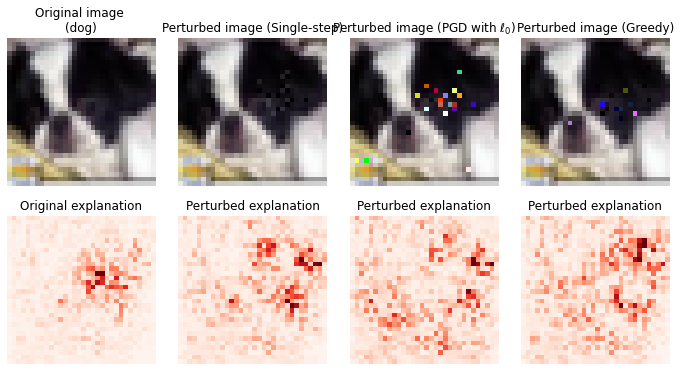

In [15]:
fig, ax = plt.subplots(2,4, figsize=(12, 6))
ax[0,0].imshow(examples[b:b+1].squeeze().permute(1,2,0).detach().cpu().numpy())
ax[0,0].set_title("Original image \n(dog)", fontsize=12)
ax[0,0].axis("off")
viz.visualize_image_attr(
    np.transpose(org_expl.squeeze().cpu().detach().numpy(), (1,2,0)),
    np.transpose(examples[b:b+1].squeeze().cpu().detach().numpy(), (1,2,0)),
    method='heat_map',
    cmap="Reds",
    show_colorbar=False,
    outlier_perc=2,
    fig_size=(4,4), plt_fig_axis=(fig, ax[1,0]), use_pyplot=False)
ax[1,0].axis("off")
ax[1,0].set_title("Original explanation", fontsize=12)

ax[0,1].imshow(x_adv_single_step[b:b+1].squeeze().permute(1,2,0).detach().cpu().numpy())
ax[0,1].axis("off")
ax[0,1].set_title("Perturbed image (Single-step)", fontsize=12)
viz.visualize_image_attr(
    np.transpose(adv_expl_single_step.squeeze().cpu().detach().numpy(), (1,2,0)),
    np.transpose(x_adv_single_step[b:b+1].squeeze().cpu().detach().numpy(), (1,2,0)),
    method='heat_map',
    cmap="Reds",
    show_colorbar=False,
    outlier_perc=2,
    fig_size=(4,4), plt_fig_axis=(fig, ax[1,1]), use_pyplot=False)
ax[1,1].axis("off")
ax[1,1].set_title("Perturbed explanation", fontsize=12)

ax[0,2].imshow(x_adv_pgd0[b:b+1].squeeze().permute(1,2,0).detach().cpu().numpy())
ax[0,2].axis("off")
ax[0,2].set_title("Perturbed image (PGD with $\ell_0$)", fontsize=12)
viz.visualize_image_attr(
    np.transpose(adv_expl_pgd0.squeeze().cpu().detach().numpy(), (1,2,0)),
    np.transpose(x_adv_pgd0[b:b+1].squeeze().cpu().detach().numpy(), (1,2,0)),
    method='heat_map',
    cmap="Reds",
    show_colorbar=False,
    outlier_perc=2,
    fig_size=(4,4), plt_fig_axis=(fig, ax[1,2]), use_pyplot=False)
ax[1,2].axis("off")
ax[1,2].set_title("Perturbed explanation", fontsize=12)

ax[0,3].imshow(x_adv_greedy[b:b+1].squeeze().permute(1,2,0).detach().cpu().numpy())
ax[0,3].axis("off")
ax[0,3].set_title("Perturbed image (Greedy)", fontsize=12)
viz.visualize_image_attr(
    np.transpose(adv_expl_greedy.squeeze().cpu().detach().numpy(), (1,2,0)),
    np.transpose(x_adv_greedy[b:b+1].squeeze().cpu().detach().numpy(), (1,2,0)),
    method='heat_map',
    cmap="Reds",
    show_colorbar=False,
    outlier_perc=2,
    fig_size=(4,4), plt_fig_axis=(fig, ax[1,3]), use_pyplot=False)
ax[1,3].axis("off")
ax[1,3].set_title("Perturbed explanation", fontsize=12)

plt.subplots_adjust(wspace=0.1);

In [19]:
num_pixels_single_step = np.sum(
    np.amax(np.abs((x_adv_single_step - examples).cpu().detach().numpy()) > 1e-10, axis=1),
    axis=(1, 2),
)

num_pixels_pgd0 = np.sum(
    np.amax(np.abs((x_adv_pgd0 - examples).cpu().detach().numpy()) > 1e-10, axis=1),
    axis=(1, 2),
)

num_pixels_greedy = np.sum(
    np.amax(np.abs((x_adv_greedy - examples).cpu().detach().numpy()) > 1e-10, axis=1),
    axis=(1, 2),
)



In [20]:
print(
    f"mean perturbation: \n
    single step: {np.mean(num_pixels_single_step)} \n
    PGD_0: {np.mean(num_pixels_pgd0)} \n
    greedy: {np.mean(num_pixels_greedy)}"
)

SyntaxError: EOL while scanning string literal (2872359233.py, line 2)